# Hard spheres model development


First stage: Develop a CNN - based GAN to work with ordered point clouds.

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Basic
from IPython.display import display

# For OS-agnostic paths
from pathlib import Path

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import numpy as np
sns.set_style("whitegrid")
from copy import deepcopy
import glob, json
from datetime import datetime
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, Dataset, TensorDataset


from torchinfo import summary

import mlflow

%cd ..
try:
    from src.utils import load_raw_data
    from src.plotting import plot_pointcloud, plot_sample_figures
    from src.models.HardSphereGAN import GAN
    from src.models.StaticScaler import StaticMinMaxScaler
finally:
    %cd -

plt.set_cmap("viridis")

/Users/veikko/Documents/GitHub/hard-spheres
/Users/veikko/Documents/GitHub/hard-spheres/Notebooks


<Figure size 640x480 with 0 Axes>

In [3]:
import os

os.environ["MLFLOW_ENABLE_SYSTEM_METRICS_LOGGING"] = "true"

## Load data

In [4]:
phis = [0.86] # Add more phis here

path = Path("../data/raw/samples")

files, dataframe, metadata = load_raw_data(path, phi=phis)

dataframe

Number of Files found :  526


class          x          y         r
experiment sample                                           
phi-0.86   sample-245      1 -21.345870 -15.024694  0.730000
           sample-245      2  20.038204 -19.199467  0.776842
           sample-245      3 -19.955206 -14.443004  0.823684
           sample-245      6 -13.669206 -10.131996  0.964211
           sample-245      4  -9.936614  -7.810038  0.870526
...                      ...        ...        ...       ...
           sample-468      2  15.738703 -21.721624  0.776842
           sample-468      3 -19.316748 -18.640416  0.823684
           sample-468     10  21.513569 -16.596960  1.151579
           sample-468      4 -17.922827 -19.644332  0.870526
           sample-468      6 -20.417054 -13.410191  0.964211

[1052000 rows x 4 columns]

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = MinMaxScaler(feature_range=(0, 1))

scaler = StaticMinMaxScaler(
    columns = ["x", "y", "r"],
    maximum = [22, 22, 22], # NOTE: Tuned for physical feasibility
    minimum = [-22, -22, -22] # NOTE: Tuned for physical feasibility
    # maximum = [21.74652425, 21.74652425, 1.62], # NOTE: Normal minmax
    # minimum = [-21.74652425, -21.74652425, 0.73]  # NOTE: Normal minmax
    # NOTE: Scale r with the higher x,y min,max -> Ensures everything is between 0,1 but also retains physical setup with linear scaling
)

dataframe_scaled = pd.DataFrame(scaler.transform(dataframe), columns=dataframe.columns)

dataframe_scaled.set_index(dataframe.index, inplace=True)

dataframe_scaled = dataframe_scaled.drop(columns=["class"]) # Redundant with r
# dataframe_scaled = dataframe_scaled.sort_values(by=["experiment", "sample"])
dataframe_scaled.describe().round(2)

,x,y,r
count,1052000.00,1052000.00,1052000.00
mean,0.50,0.50,0.52
std,0.29,0.29,0.01
min,0.01,0.01,0.52
25%,0.25,0.25,0.52
50%,0.50,0.50,0.52
75%,0.75,0.75,0.53
max,0.99,0.99,0.54


### Attempt: Order dataframe based on Xy coordinates

This is done to introduce the spatial relationship that a CNN can utilize.


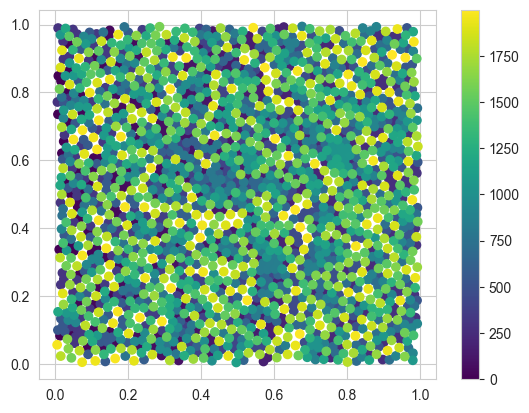

In [6]:
_X = dataframe_scaled.copy()


_X["Xy"] = np.sqrt(((_X["x"]-0.5)**2) + ((_X["y"]-0.5)**2))
_X["Xy"] = _X["r"]# + _X["y"] # Think about starting from center and going radially outwards
# _X["Xy"] = _X["r"] # Think about starting from center and going radially outwards

_X = _X.query("experiment=='phi-0.86'&sample=='sample-1'")

_X = _X.sort_values(by=["r", "x", "y"])

_X = _X.reset_index(drop=True)

_X

plt.scatter(x=_X.values[:,0], y=_X.values[:,1], c=_X.index)

plt.colorbar()

This is better than not ordered, but can be problematic as values in the middle have a high probability of ending up with non-neighbouring samples.

However it is also a good experiment as if we observe that the corners behave better than the middle, we know we are on to something.

In [7]:
dataframe_scaled_ordered = dataframe_scaled.copy()
dataframe_scaled_ordered = dataframe_scaled_ordered.sort_values(by=["experiment", "sample", "r"])
dataframe_scaled_ordered

x         y         r
experiment sample                                 
phi-0.86   sample-1   0.063381  0.181152  0.516591
           sample-1   0.067027  0.264312  0.516591
           sample-1   0.042969  0.501985  0.516591
           sample-1   0.457638  0.576509  0.516591
           sample-1   0.986067  0.579203  0.516591
...                        ...       ...       ...
           sample-99  0.413415  0.915327  0.536818
           sample-99  0.754866  0.728814  0.536818
           sample-99  0.257066  0.870888  0.536818
           sample-99  0.824746  0.257858  0.536818
           sample-99  0.930153  0.589395  0.536818

[1052000 rows x 3 columns]

## Build dataset

Creating Dataset
Descriptor List:  ['phi', 'r']
torch.Size([526, 1, 1])
torch.Size([526, 1, 2000, 3])


<Axes: >

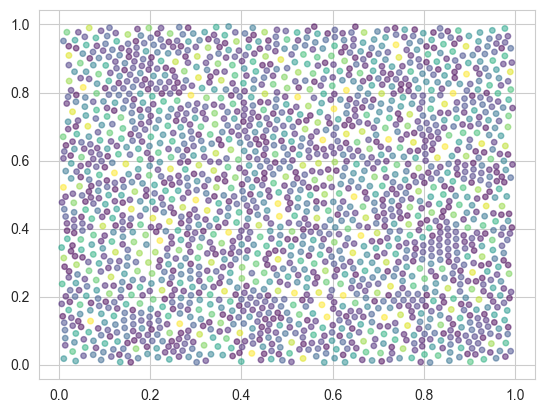

In [ ]:
from src.HSDataset import HSDataset

dataset = HSDataset(
    dataframe_scaled_ordered.copy(), # Dont use the ordering
    descriptor_list=["phi", "r"],
    synthetic_samples={
        "rotational": 0,
        "shuffling": 0,
        "spatial_offset_static": 0,
        "spatial_offset_repeats": 0
        }, 
    downsample=0
)
print(dataset[:][0].shape)
print(dataset[:][1].shape)
# Create a function that visualizes the point cloud

plot_pointcloud(dataset[2][1], plot_radius=True)

<Axes: >

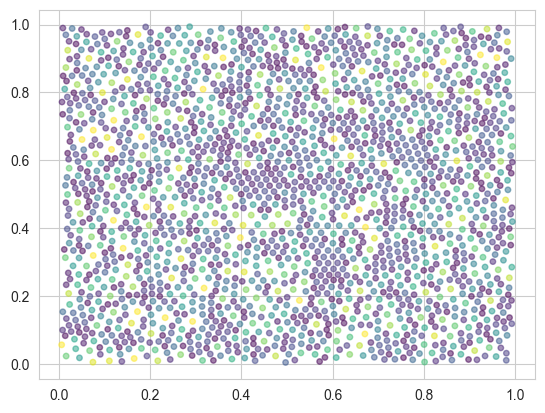

In [9]:
plot_pointcloud(dataset[0][1], plot_radius=True)


Text(0.5, 1.0, 'Mean Point Cloud, n=1')

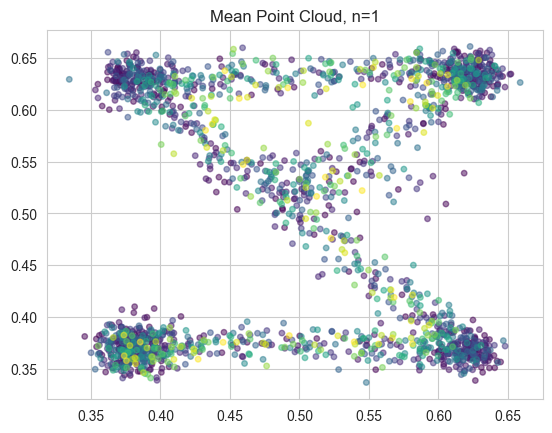

In [10]:
plot_pointcloud(dataset[:][1][:,:,:].mean(dim=0), plot_radius=True)

plt.title("Mean Point Cloud, n={}".format(len(dataset[:][1][0])))

## Note: Samples are order invariant in the sample size dimension

<Axes: >

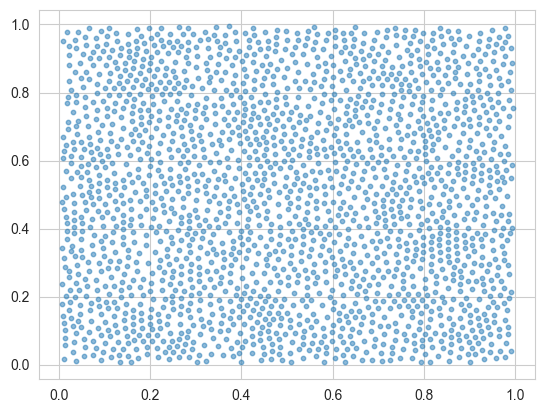

In [11]:
plot_pointcloud(reversed(dataset[2][1]), plot_radius=False)

# Create model

Create a GAN architecture, which creates point clouds $\hat{y}$ based on the descriptor(s) $\hat{X}$ and a random noise vector $\hat{z}$.

In [12]:
sample_x = dataset[0:32][0].cpu()#.transpose(-1,-2)
sample_y = dataset[0:32][1].cpu()

sample_x_mps = sample_x.to("mps")
sample_y_mps = sample_y.to("mps")

print(sample_x.shape, sample_y.shape)


torch.Size([32, 1, 1]) torch.Size([32, 1, 2000, 3])


torch.Size([32, 1, 1])
torch.Size([32, 1, 2000, 2])
Layer (type:depth-idx)                   Output Shape              Param #
CCCGenerator                             [32, 1, 2000, 2]          --
├─Sequential: 1-1                        [32, 1, 2000, 2]          --
│    └─Linear: 2-1                       [32, 60000]               120,060,000
│    └─ReLU: 2-2                         [32, 60000]               --
│    └─Unflatten: 2-3                    [32, 30, 2000, 1]         --
│    └─ConvTranspose2d: 2-4              [32, 256, 2000, 2]        15,616
│    └─BatchNorm2d: 2-5                  [32, 256, 2000, 2]        512
│    └─ReLU: 2-6                         [32, 256, 2000, 2]        --
│    └─ConvTranspose2d: 2-7              [32, 512, 2000, 2]        131,584
│    └─BatchNorm2d: 2-8                  [32, 512, 2000, 2]        1,024
│    └─ReLU: 2-9                         [32, 512, 2000, 2]        --
│    └─ConvTranspose2d: 2-10             [32, 256, 2000, 2]        131,328
│    └

<Axes: >

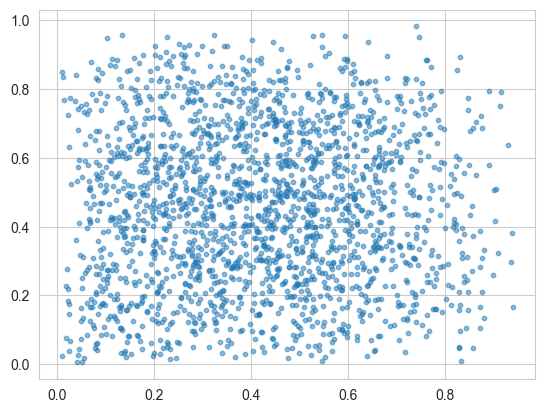

In [35]:
# Make a generator model as described in the paper
# paper: https://arxiv.org/pdf/2404.06734

in_features = 64
kernel_size = (3,3) # if 3x3, the output x,y,r will correlate with each other
stride = (1,1)

from src.models.CryinGAN import Generator, CCCGenerator

out_samples = dataset.samples[0].shape[1]

out_dimensions = 2 # ONLY COORDS

generator_model_2 = CCCGenerator(
    kernel_size=1,
    stride=1,
    rand_features=out_samples,
    out_dimensions=out_dimensions,
    latent_dim=30,
    out_samples=out_samples,
    fix_r=sample_y_mps[0,:,:,2]
    ).to("mps")

# sample_x = sample_x.to("mps")
print(sample_x.shape)
_out = generator_model_2(sample_x_mps).detach()
print(_out.shape)

# softmaxed_r = generator_model_2._softmax_radius_dimensions(_out)
_out_torch = _out
_out = _out.cpu().numpy()

print(summary(generator_model_2, input_data=sample_x, depth=2))


plot_pointcloud(_out[0], plot_radius=False)
# plt.xlim(0,1)
# plt.ylim(0,1)

In [47]:
import torch
import torch.nn as nn
from src.models.CryinGAN import Discriminator2D, CCCGDiscriminator

# Initialize the discriminator
input_channels = sample_y.shape[-1] # For fractional coordinates
in_samples = sample_y.shape[1] # For fractional coordinates
idx, n_atoms_elements = torch.unique(dataset[0][1][:,:,2], return_counts=True)

discriminator_model_2 = CCCGDiscriminator(
    n_atoms_elements=n_atoms_elements,
    input_channels=input_channels,
    in_samples=in_samples
    ).to("mps")

# Print the discriminator architecture

# Example input with batch size of 16 and 3 input channels (for fractional coordinates)
B = 32
sample_x = dataset[0:B][0].cpu()#.transpose(-1,-2)
sample_y = dataset[0:B][1].cpu()

sample_x_mps = sample_x.to("mps")
sample_y_mps = sample_y.to("mps")

print(sample_x.shape, sample_y.shape)

output = discriminator_model_2(sample_y_mps)
print(output.shape)

summary(discriminator_model_2, input_data=sample_y_mps, depth=2)

torch.Size([32, 1, 1]) torch.Size([32, 1, 2000, 3])
torch.Size([32, 1])


Layer (type:depth-idx)                   Output Shape              Param #
CCCGDiscriminator                        [32, 1]                   --
├─Sequential: 1-1                        [32, 256, 2000, 1]        --
│    └─Conv2d: 2-1                       [32, 512, 2000, 1]        2,048
│    └─LeakyReLU: 2-2                    [32, 512, 2000, 1]        --
│    └─Conv2d: 2-3                       [32, 512, 2000, 1]        262,656
│    └─LeakyReLU: 2-4                    [32, 512, 2000, 1]        --
│    └─Conv2d: 2-5                       [32, 256, 2000, 1]        131,328
│    └─LeakyReLU: 2-6                    [32, 256, 2000, 1]        --
├─Sequential: 1-2                        [32, 200]                 --
│    └─Linear: 2-7                       [32, 1000]                5,121,000
│    └─LeakyReLU: 2-8                    [32, 1000]                --
│    └─Linear: 2-9                       [32, 200]                 200,200
│    └─LeakyReLU: 2-10                   [32, 200]          

## Train the model

Creating Dataset
Descriptor List:  ['phi']
torch.Size([526, 1, 2000, 2])


Text(0.5, 1.0, 'Point Cloud, n=2000')

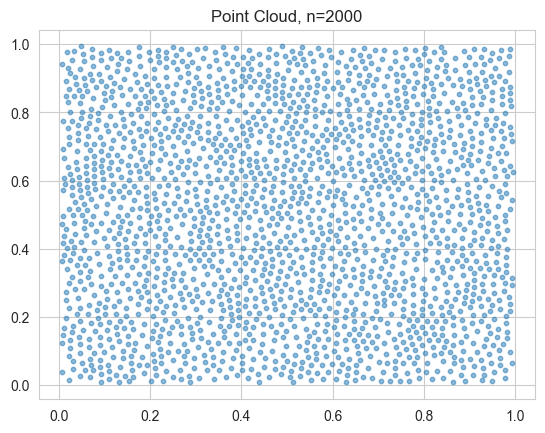

In [118]:
run_params = {
    "comment": "Fixed + new discriminator",
    "training":{
        "device": "mps" if torch.backends.mps.is_available() else "cpu", # MPS is not supported by PyTorch 2D TransposeConv
        "batch_size": 32,
        "epochs": 5000,
        "early_stopping_patience": 20,
        "early_stopping_headstart": 0,
        "early_stopping_tolerance": 1e-3, # Gradient norm based
        "log_image_frequency": 3,
        "generator_headstart": 0,
        "training_ratio_dg": 3,
        "optimizer_g": {
            "name": "Adam",
            "lr": 0.001, # 0.00005, #0.002,  # 0.001
            # "hypergrad_lr": 1e-6,
            "weight_decay": 0,
            "betas": (0.5, 0.999)
        },
        "optimizer_d": {
            "name": "Adam",
            "lr": 0.001, #0.002, 
            # "hypergrad_lr": 1e-6,
            "weight_decay": 0,
            "betas": (0.5, 0.999)
        },
        "d_loss":{
            "name": "CryinGANDiscriminatorLoss", # CryinGANDiscriminatorLoss for WaGAN + L1 loss, BCELoss for baseline
            "mu": 10, # L1 loss coefficient
        },
        "g_loss":{
            "name": "HSGeneratorLoss",
            "radius_loss": 0,
            "grid_density_loss": 0,
            "gan_loss": 1,
            "distance_loss": 0,
            "physical_feasibility_loss": 0,
            "grid_order_loss":0,
            "coefficients":{
                "gan_loss": 1,
                "radius_loss": 0,
                "grid_density_loss": 0,
                "physical_feasibility_loss": 0,
                "distance_loss": 0,
                "grid_order_loss": 0,
                "grid_order_k": 5,
            },
        }
    },
    "dataset":{
        "descriptor_list": ["phi"],
        "keep_r":False,
        "synthetic_samples":{
            "rotational": 0,
            "shuffling": 0,
            "spatial_offset_static": 0,
            "spatial_offset_repeats": 0,
            }, # NOTE: Could do subsquares and more rotations.
        "downsample": 0,
    },

}

# dataframe_scaled_ordered_filtered = dataframe_scaled_ordered[np.isclose(dataframe_scaled_ordered["r"], 0.521914)]

dataset = HSDataset(
    dataframe_scaled_ordered.copy(), # NOTE: Ordered -> ordered by radius.
    **run_params["dataset"]
    )
print(dataset.y.shape)

plot_pointcloud(dataset[:][1][4], plot_radius=False)

plt.title("Point Cloud, n={}".format(len(dataset[:][1][0,0,:,:])))

In [120]:
from src.models.CryinGAN import CCCGDiscriminator, CCCGeneratorWithDiffusion, CCCGenerator

test_frac = 0.2
kernel_size = (3,3)
dataset = dataset.to(run_params["training"]["device"])

dataset = dataset.to(run_params["training"]["device"])
trainset, testset = torch.utils.data.random_split(dataset, [1-test_frac, test_frac])

sample_x = dataset[0:32][0].cpu()#.transpose(-1,-2)
sample_y = dataset[0:32][1].cpu()

sample_x_mps = sample_x.to("mps")
sample_y_mps = sample_y.to("mps")

out_samples = dataset.samples[0].shape[1]
out_dimensions = 2 # dataset.samples[0].shape[2]

kernel_size = (1,1)
stride=1

generator = CCCGenerator(
    kernel_size=kernel_size,
    stride=stride,
    channels_coefficient=1,
    rand_features=64,# 513 for one paper, 64 for another,
    out_dimensions=out_dimensions,
    out_samples=out_samples,
    latent_dim=128, # 128 for the papers
    fix_r=None,
    clip_output = False
    # (
    #     dataset.y.min(dim=0).values.min(dim=0).values,
    #     dataset.y.max(dim=0).values.max(dim=0).values
    # )
    ).to("mps")

input_channels = out_dimensions # Only x,y, no z or r

discriminator = CCCGDiscriminator(
    input_channels=input_channels, 
    in_samples=sample_y.shape[1], 
    channels_coefficient=1,
    n_atoms_elements=n_atoms_elements, # For fractional coordinates
    ).to("mps")

gan = GAN(
    dataset, 
    dataset,# No separate test set
    generator_model=generator,
    discriminator_model=discriminator,
    **run_params
    )

print(summary(gan.generator, input_data=sample_x_mps, depth=2))
print(summary(gan.discriminator, input_data=sample_y_mps, depth=2))

_out = gan.generate(sample_x)
discriminator_out = gan.discriminator(_out.to("mps"))

plot_pointcloud(_out[0], plot_radius=False)

IndexError: index 2 is out of bounds for dimension 2 with size 2

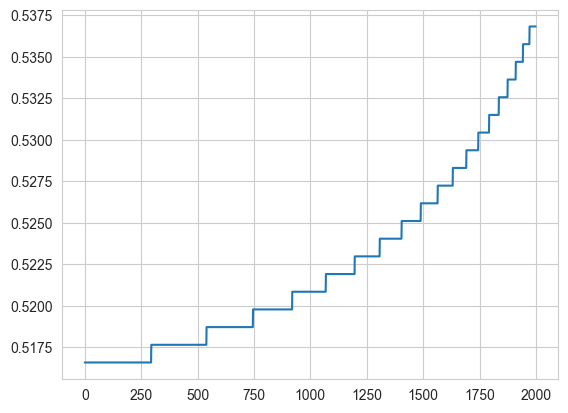

In [106]:
plt.plot(gan.trainset[0][1][0,:,2].cpu())

In [109]:
n_atoms_elements

tensor([295, 245, 206, 174, 149, 128, 111,  97,  85,  75,  67,  60,  53,  48,
         43,  39,  36,  32,  29,  28], device='mps:0')

In [116]:
sample_y.shape

sample_y[0,0,][:295]

tensor([[0.0634, 0.1812, 0.5166],
        [0.0670, 0.2643, 0.5166],
        [0.0430, 0.5020, 0.5166],
        [0.4576, 0.5765, 0.5166],
        [0.9861, 0.5792, 0.5166],
        [0.0929, 0.5334, 0.5166],
        [0.9910, 0.5628, 0.5166],
        [0.1537, 0.2035, 0.5166],
        [0.2763, 0.2864, 0.5166],
        [0.2839, 0.0849, 0.5166],
        [0.1645, 0.4581, 0.5166],
        [0.9139, 0.5467, 0.5166],
        [0.2213, 0.2005, 0.5166],
        [0.1770, 0.2910, 0.5166],
        [0.3504, 0.1705, 0.5166],
        [0.9276, 0.2230, 0.5166],
        [0.2983, 0.5254, 0.5166],
        [0.9520, 0.4884, 0.5166],
        [0.3653, 0.5458, 0.5166],
        [0.1010, 0.3289, 0.5166],
        [0.1640, 0.5569, 0.5166],
        [0.9845, 0.2050, 0.5166],
        [0.9597, 0.5424, 0.5166],
        [0.0740, 0.5091, 0.5166],
        [0.3342, 0.1424, 0.5166],
        [0.9866, 0.3998, 0.5166],
        [0.3437, 0.2166, 0.5166],
        [0.0624, 0.5674, 0.5166],
        [0.9251, 0.5341, 0.5166],
        [0.172

In [88]:
sample_size = out_samples

# run 'mlflow server --host 127.0.0.1 --port 8080' before starting training
gan.train_n_epochs(
    epochs=run_params["training"]["epochs"],
    batch_size=run_params["training"]["batch_size"],
    experiment_name=f"Fullscale, new discriminator, sample size = {sample_size}",
    requirements_file = Path("../top-level-requirements.txt"),
    save_model=True
)

2025/04/12 16:42:17 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2025/04/12 16:42:17 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Using requirements file: /Users/veikko/Documents/GitHub/hard-spheres/top-level-requirements.txt
Starting run moon-moon-38ba7932-70fd-4b25-a6a6-c87c1951e8f4...
Time: 2025-04-12 16:42:17


  0%|          | 0/5000 [00:26<?, ?it/s]
2025/04/12 16:42:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run moon-moon-38ba7932-70fd-4b25-a6a6-c87c1951e8f4 at: http://127.0.0.1:8080/#/experiments/295908541939514415/runs/a038e96dda32445081f70fd53edcd2fe.
2025/04/12 16:42:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/295908541939514415.
2025/04/12 16:42:43 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/04/12 16:42:43 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


KeyError: 'metrics'

In [ ]:
# Compute the gradients for plotting

real_images = sample_y_mps
fake_images = gan.generate(sample_x_mps).to(real_images.device)

alpha = torch.rand(real_images.size(0), 1, 1).to(real_images.device)
interpolates_coord = alpha * real_images + (1 - alpha) * fake_images
interpolates_coord = interpolates_coord.requires_grad_(True)
d_interpolates_coord = discriminator(interpolates_coord)

grad_outputs_coord = torch.ones_like(d_interpolates_coord)

gradients = torch.autograd.grad(
    outputs=d_interpolates_coord,
    inputs=interpolates_coord,
    grad_outputs=grad_outputs_coord,
    create_graph=True,
    retain_graph=True,
    only_inputs=True,
    is_grads_batched=False,
)[0]

# Plot the points and the related gradients
plt.figure(figsize=(10,10))
# plt.scatter(x=real_images[0,:,0].cpu(), y=real_images[0,:,1].cpu(), c="blue", alpha=0.5,marker=".", label="Real")
plt.scatter(x=interpolates_coord[0,:,0].cpu().detach(), y=interpolates_coord[0,:,1].cpu().detach(), c="green", alpha=0.5,marker=".", label="Interpolated")
# plt.scatter(x=fake_images[0,:,0].cpu(), y=fake_images[0,:,1].cpu(), c="red", alpha=0.5,marker=".",label="Fake")

plt.quiver(
    interpolates_coord[0,:,0].cpu().detach(),
    interpolates_coord[0,:,1].cpu().detach(),
    gradients[0,:,0].cpu().detach(),
    gradients[0,:,1].cpu().detach(),
    alpha=0.5,
)
plt.xlim(.25,.75)
plt.ylim(.25,.75)
plt.legend()

In [ ]:
_out = gan.generate(sample_x)[0]
# _out = _out.numpy()

plot_pointcloud(_out, plot_radius=False)


## Test the discriminator with random data

In [ ]:
# Test the discriminator with random data

# Generate random data
random_data = torch.rand_like(sample_y).to("mps")
random_data = torch.randn_like(sample_y).to("mps")
print(random_data.shape)

plot_pointcloud(random_data[0].cpu().numpy(), plot_radius=False)

# Test the discriminator

output = gan.discriminator(random_data)
print(output.shape)
print("Mean of discriminator output:", output.mean().item())
plt.title(f"Discriminator output: {output[0].item()}")
plt.show()

# Profile model performance for computational bottlenecks

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        gan.generator(sample_x)


In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        gan.discriminator(sample_y_mps)

    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

### OPEN QUESTIONS

- What to do with the metadata?
- Class and radius are redundant. Is the real physical measure numerical or categorical / quantified? 

In [ ]:
metadata.round(5).drop_duplicates()

## Pointnet

In [ ]:
from pointnet.dataset import ShapeNetDataset, ModelNetDataset
from pointnet.model import PointNetCls, feature_transform_regularizer, PointNetfeat

In [ ]:
summary(PointNetfeat(), input_size=(32, 3, 1024))